# Итоговое задание Модуль 2 DST-28

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_columns', 30) # показывать больше колонок

In [4]:
students = pd.read_csv('stud_math.csv')

In [5]:
students.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


## Посмотрим какие данные находятся в нашем датасете

In [6]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

В нашем датасете 30 колонок и 395 строк. Из 30 колонок 13 числовых признаков и 17 строковых. Только в 3-х колонках нет пропусков. Пропуски по нечисловым данным заполнить достаточно сложно. Я предлагаю обращать внимание на проблему пропусков только в том случае, если количество пропусков больше 10% от всего датасета.

In [7]:
# В датасете есть один столбец, который не описан в задании, имеет странные отрицательные значения 
# Это столбец "studytime, granular", возможно это какая-то производная величина от признака studytime. 
# Предлагаю избавиться от него
students = students.drop('studytime, granular', 1)

## Проанализируем данные по каждому столбцу

In [8]:
#Посмотрим, сколько школ содержит наш датасет
pd.DataFrame(students.school.value_counts())

,school
GP,349
MS,46


Оказывается в Датасете всего 2 школы. Причем преобладающее количество учеников приходится на школу с индексом GP

In [9]:
#Оценим распределение учеников по полу
pd.DataFrame(students.sex.value_counts())

,sex
F,208
M,187


Девочек немного больше, чем мальчиков. Но разница незначительная

In [11]:
#Оценим распределение учеников по возрасту
pd.DataFrame(students.age.value_counts())

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


Мы видим, что большиснтво учеников находятся в возрастных рамках от 16-19 лет, но есть несколько человек, которые старше. Проверим, не являются ли возрастные группы старше 19 лет выбросами

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


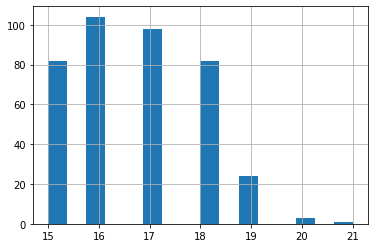

In [12]:
agemedian = students.age.median()
ageIQR = students.age.quantile(0.75) - students.age.quantile(0.25)
ageperc25 = students.age.quantile(0.25)
ageperc75 = students.age.quantile(0.75)
print('25-й перцентиль: {},'.format(ageperc25), '75-й перцентиль: {},'.format(ageperc75)
      , "IQR: {}, ".format(ageIQR),"Границы выбросов: [{f}, {l}].".format(f=ageperc25 - 1.5*ageIQR, l=ageperc75 + 1.5*ageIQR))
students.age.loc[students.age.between(ageperc25 - 1.5*ageIQR, ageperc75 + 1.5*ageIQR)].hist(bins = 16, label = 'IQR')

Что ж, статистически возвраст выше 20 лет не является выбросом, но поскольку таких учеников очень мало, предлагаю привести их возраст к 19 годам и условиться, что эту возрастную категорию мы будем рассматривать как 19+

In [13]:
#Функция, которая приравнивает возраст старше 19 к 19 годам
students.age = students.age.apply(lambda x: 19 if x > 19 else x)

In [14]:
#Теперь посмотрим на значения адреса
pd.DataFrame(students.address.value_counts())

,address
U,295
R,83


In [15]:
# Пропущенные значения
students.address.isnull().sum()

17

Мы видим, что бОльшая часть студентов живет в городе. Также у этого признака есть пропущенные значения. Но я пока не вижу смысла их заполнять

In [16]:
#Взглянем на признак "размер семьи"
pd.DataFrame(students.famsize.value_counts())

,famsize
GT3,261
LE3,107


In [17]:
# Пропущенные значения
students.famsize.isnull().sum()

27

In [18]:
#Взглянем на признак "Статус совместного жилья родителей"
pd.DataFrame(students.Pstatus.value_counts())

,Pstatus
T,314
A,36


In [19]:
# Пропущенные значения
students.Pstatus.isnull().sum()

45

Видно что по признаку "Статус совместного жилья родителей" у нас достаточно много пропущенных значений. Было бы неплохо заполнить эти пропуски. К сожалению, заполнить их адекватными значениями не представляется возможным в рамках данного датасета.

In [20]:
#Анализируем образование матери
pd.DataFrame(students.Medu.value_counts())

,Medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


In [21]:
# Пропущенные значения
students.Medu.isnull().sum()

3

In [22]:
#Анализируем образование отца
pd.DataFrame(students.Fedu.value_counts())

,Fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


Похоже, что значение 40 - это просто ошибка ввода, скорее всего там должно было быть 4. Предлагаю исправить эту ошибку

In [23]:
#Функция, которая исправляет ошибочное значение в признаке "Образование отца"
students.Fedu = students.Fedu.apply(lambda x: 4 if x == 40 else x)

In [24]:
# Проверка
pd.DataFrame(students.Fedu.value_counts())

,Fedu
2.0,106
3.0,96
4.0,89
1.0,78
0.0,2


In [25]:
#Анализируем работу матери
pd.DataFrame(students.Mjob.value_counts())

,Mjob
other,133
services,98
at_home,58
teacher,55
health,32


In [26]:
# Пропущенные значения
students.Mjob.isnull().sum()

19

In [27]:
#Анализируем работу отца
pd.DataFrame(students.Fjob.value_counts())

,Fjob
other,197
services,102
teacher,29
at_home,16
health,15


In [28]:
# Пропущенные значения
students.Fjob.isnull().sum()

36

In [29]:
#Анализируем причину выбора школы
pd.DataFrame(students.reason.value_counts())

,reason
course,137
home,104
reputation,103
other,34


In [30]:
# Пропущенные значения
students.reason.isnull().sum()

17

In [31]:
#Анализируем опекунов
pd.DataFrame(students.guardian.value_counts())

,guardian
mother,250
father,86
other,28


In [32]:
# Пропущенные значения
students.guardian.isnull().sum()

31

In [33]:
#Анализируем время в пути до школы
pd.DataFrame(students.traveltime.value_counts())

,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


In [34]:
# Пропущенные значения
students.traveltime.isnull().sum()

28

In [35]:
#Поскольку значений 4 (> 60 мин) в датасете очень мало, предлагаю объединить 3 и 4 в единый интервал (>30 мин)
students.traveltime = students.traveltime.apply(lambda x: 3 if x == 4 else x)

In [36]:
#Анализируем время на учебу помимо школы
pd.DataFrame(students.studytime.value_counts())

,studytime
2.0,194
1.0,103
3.0,64
4.0,27


In [37]:
# Пропущенные значения
students.studytime.isnull().sum()

7

In [38]:
#Анализируем количество внеучебных неудач
pd.DataFrame(students.failures.value_counts())

,failures
0.0,293
1.0,49
2.0,16
3.0,15


In [39]:
# Пропущенные значения
students.failures.isnull().sum()

22

Поскольку больше одной учебной неудачи встречается достаточно редко, изменить данные этого признака следующим образом:
0 - не было внеучебных неудач, 1 - внеучебные неудачи были

In [40]:
students.failures = students.failures.apply(lambda x: 1 if x > 1 else x)

In [41]:
# Проверка
pd.DataFrame(students.failures.value_counts())

,failures
0.0,293
1.0,80


In [42]:
# Анализируем дополнительную образовательную поддержку
pd.DataFrame(students.schoolsup.value_counts())

,schoolsup
no,335
yes,51


In [43]:
# Пропущенные значения
students.schoolsup.isnull().sum()

9

In [44]:
# Анализируем семейную образовательную поддержку
pd.DataFrame(students.famsup.value_counts())

,famsup
yes,219
no,137


In [45]:
# Пропущенные значения
students.famsup.isnull().sum()

39

In [46]:
# Анализируем посещение платных занятий по математике
pd.DataFrame(students.paid.value_counts())

,paid
no,200
yes,155


In [47]:
# Пропущенные значения
students.paid.isnull().sum()

40

Как видим по признаку "дополнительные платные занятий по математике" у нас тоже достаточно много пропусков. Но заменить их чем-то адекватным не представляется возможным.

In [48]:
# Дополнительные внеучебные занятия
pd.DataFrame(students.activities.value_counts())

,activities
yes,195
no,186


In [49]:
# Пропущенные значения
students.activities.isnull().sum()

14

In [50]:
# Анализируем информацию о посещении детского сада
pd.DataFrame(students.nursery.value_counts())

,nursery
yes,300
no,79


In [51]:
# Пропущенные значения
students.nursery.isnull().sum()

16

In [52]:
# Анализируем желание получить высшее образование
pd.DataFrame(students.higher.value_counts())

,higher
yes,356
no,19


In [53]:
# Пропущенные значения
students.higher.isnull().sum()

20

In [54]:
# Анализируем наличие Интернета дома
pd.DataFrame(students.internet.value_counts())

,internet
yes,305
no,56


In [55]:
# Пропущенные значения
students.internet.isnull().sum()

34

In [56]:
# Анализируем наличие романтических отношений
pd.DataFrame(students.romantic.value_counts())

,romantic
no,240
yes,124


In [57]:
# Пропущенные значения
students.romantic.isnull().sum()

31

In [58]:
# Анализируем семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
pd.DataFrame(students.famrel.value_counts())

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


In [59]:
# Пропущенные значения
students.famrel.isnull().sum()

27

В данном признаке есть число не соответствующее шкале (-1). Скорее всего это - ошибка ввода. Заменим его на 1.

In [60]:
students.famrel = students.famrel.apply(lambda x: 1 if x == -1 else x)

In [61]:
# Проверка
pd.DataFrame(students.famrel.value_counts())

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,8


In [62]:
# Анализируем свободное время после школы (от 1 - очень мало до 5 - очень мого)
pd.DataFrame(students.freetime.value_counts())

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


In [63]:
# Пропущенные значения
students.freetime.isnull().sum()

11

In [64]:
# Анализируем проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
pd.DataFrame(students.goout.value_counts())

,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


In [65]:
# Пропущенные значения
students.goout.isnull().sum()

8

In [66]:
# Анализируем текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
pd.DataFrame(students.health.value_counts())

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


In [67]:
# Пропущенные значения
students.health.isnull().sum()

15

In [68]:
# Анализируем количество пропущенных занятий
pd.DataFrame(students.absences.value_counts())

,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,12
3.0,8
16.0,7


Пожоже, что в этом признаке есть выбросы. Давайте проверим на наличие выбросов c помощью графика

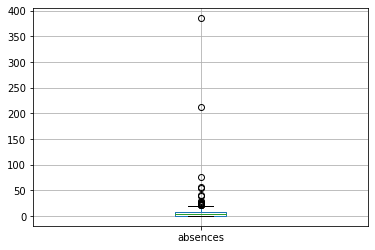

In [69]:
boxplot = students.boxplot(column = ['absences'])

Похоже, что выбросов достаточно много. Посчитаем границы выбросов

In [70]:
# Функция для расчета границ выбросов по признаку "Количество пропущенных занятий"
missmedian = students.absences.median()
print(missmedian)
missIQR = students.absences.quantile(0.75) - students.absences.quantile(0.25)
missperc25 = students.absences.quantile(0.25)
print(missperc25)
missperc75 = students.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(missperc25), '75-й перцентиль: {},'.format(missperc75)
      , "IQR: {}, ".format(missIQR),"Границы выбросов: [{f}, {l}].".format(f=missperc25 - 1.5*missIQR, l=missperc75 + 1.5*missIQR))

4.0
0.0
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


Нижняя граница выбросов в данном случае нерелевантна, поскольку отрицательных значений признака в датасете нет. Зафиксируем пока, что верхняя граница выброса равна 20.

In [71]:
# Анализируем баллы по экзамену по математике
pd.DataFrame(students.score.value_counts())

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


In [72]:
# Пропущенные значения
students.score.isnull().sum()

6

Удалим строки с пропущенными значениями score, так как проанализировать эти данные не получится

In [73]:
students.dropna(subset=['score'], inplace=True)

In [74]:
# Проверка
students.score.isnull().sum()

0

Из предварительного анализа столбцов видно, что есть только два реальных числовых стобца, которые пригодны для построения корреляции между ними и оценкой по математике. Это столбцы age и absences.
Для начала попробуем вычислить корреляцию между столбцами age и score

Взглянем для начала на графики зависимостей этим переменых (pairplot)

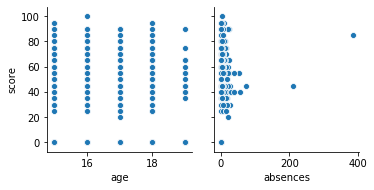

In [90]:
sns.pairplot(data=students, x_vars=['age', 'absences'], y_vars=['score'])

Как видно из графиков, каких-либо сильных зависимостей между анализируемыми параметрами нет. Единственное, что можно отметить из второго графика, это то, что похоже, те ученики, которые пропускали много уроков по математике склонны к получению баллов средних и ниже среднего.

Проверим корреляцию между возрастом, пропущенными занятиями и оценкой по математике.

In [76]:
students.corr().loc['age','score']

-0.16119687432647103

Мы видим, что есть непрямая зависимость между оценкой по математике и возрастом студентов. 
Т.е. с возрастом средняя оценка по математике снижается. Почему так происходит - непонятно. Тем не менее эта обратная зависимость несущественна

Теперь вычислим корреляцию между количеством пропущенных занятий и оценкой по математике

In [77]:
students.corr().loc['absences','score']

0.06528298441888772

Корреляция положительная, но совсем незначительная. Попробуем поработать с данными в столбце absences.
Во-первых, в столбце absences есть пропуски. Удалять эти строки пока не хочется, поэтому создадим копию датафрейма 
для проверки гипотез

In [78]:
students.absences.isnull().sum()

11

In [79]:
students2 = students.copy()

In [80]:
students2.dropna(subset=['absences'], inplace=True)

In [81]:
students2.corr().loc['absences','score']

0.06528298441888772

Как видим, после удаления пустых значений, корреляция не поменялась

Однако мы помним, что в столбце absences присутствуют выбросы. 
Попробуем избавиться от выбросов и посмотреть, повлияет ли это на корреляцию

In [82]:
# Удаляем выбросы из колонки с пропущенными занятиями
students2 = students2.loc[students2['absences'] < 21]

In [83]:
# Посмотрим сколько строк у нас осталось, после удаления выбросов и пустых значений
len(students2)

361

In [84]:
students2.corr().loc['absences','score']

0.08127414060470324

Как мы видим значение корреляции увеличилось после удаления выбросов, однако оно по-прежнему остается незначительным.

<b>Вывод:</b> Значимой связи между оценкой по математике и такими признаками как возраст ученика или количество пропущенных уроков не найдено

## Теперь попробуем поработать с нечисловыми признаками, а также с признаками, которые принимают значение в рамках какой-либо шкалы, как например, состояние здоровья

Для начала попробуем визуализировать значения с помощью boxplot

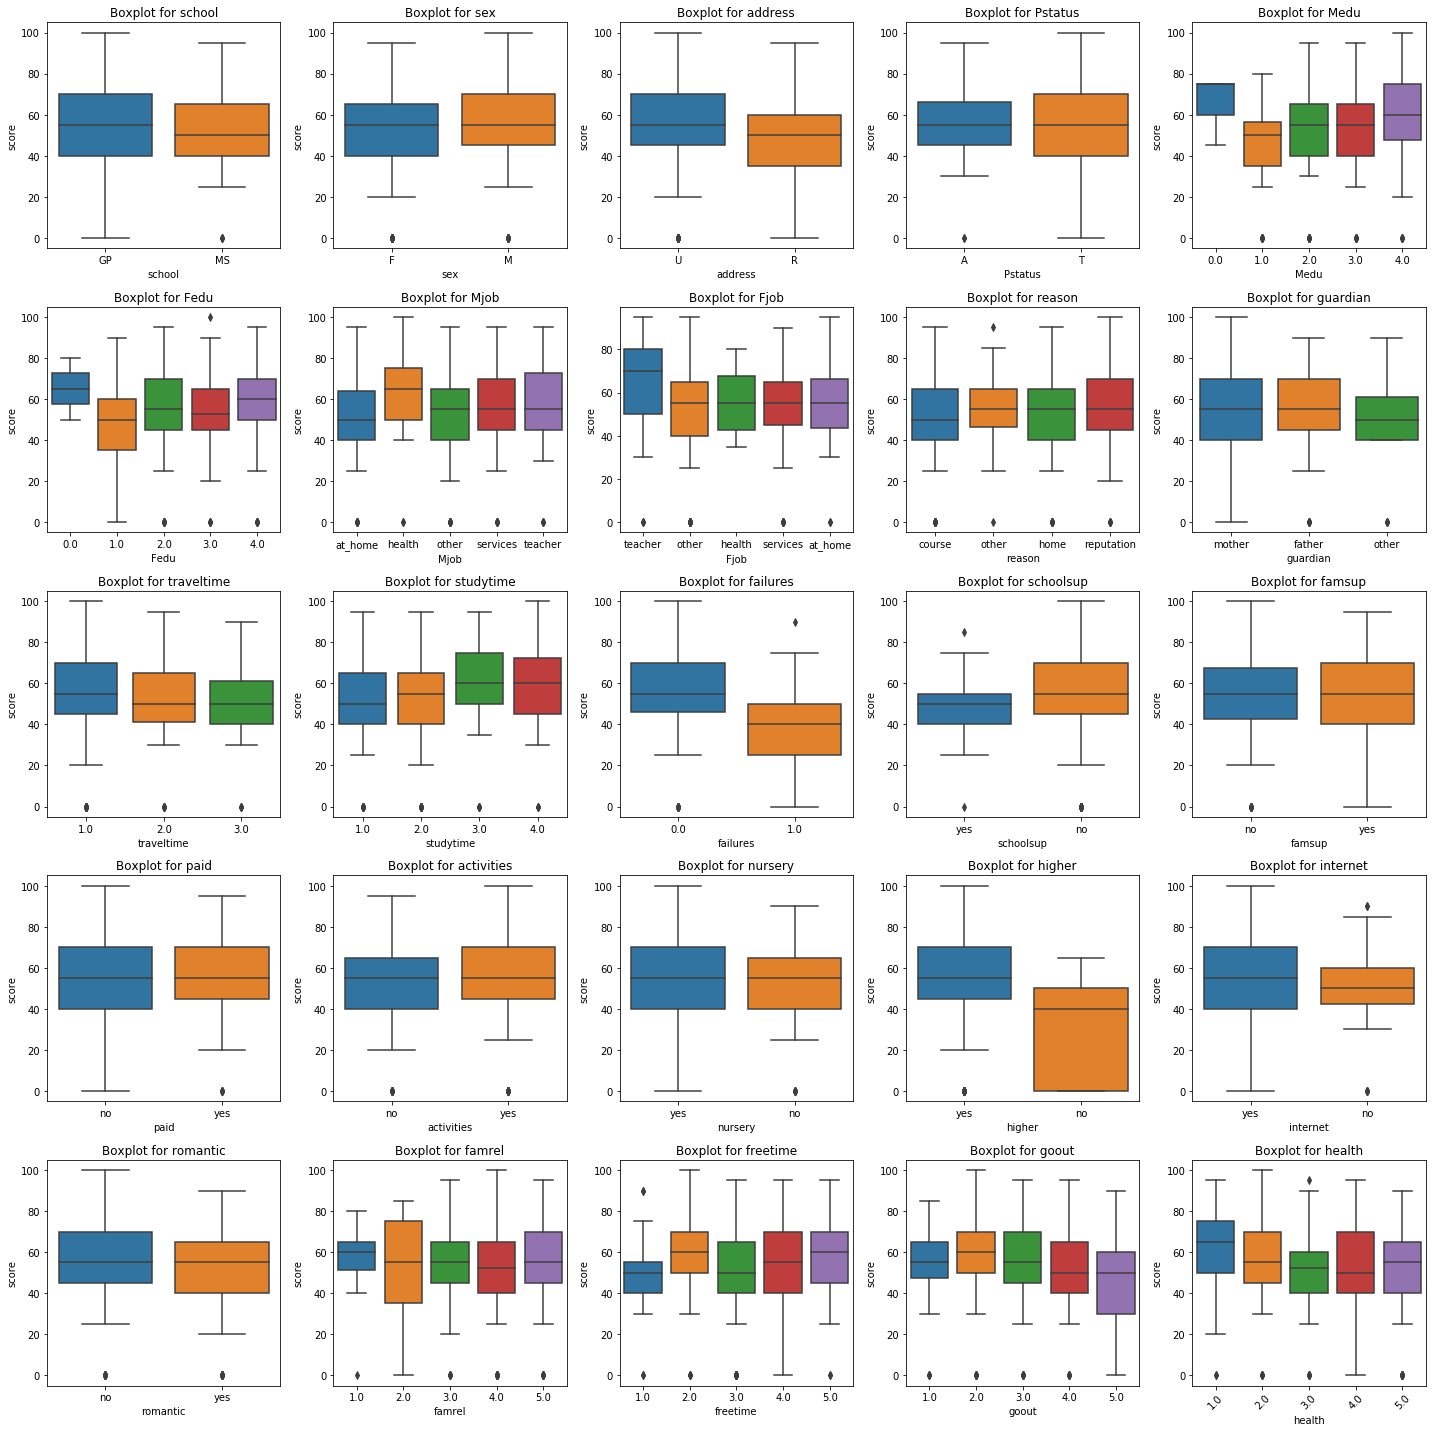

In [85]:
fig, axes = plt.subplots(5, 5, figsize=(20,20)) # разбиваем канвас на грид 5x5 по количеству признаков для отображения
axes = axes.flatten() # переводим двумерный массив осей в одномерный для корректной индексации

i = 0
for col in ['school', 'sex', 'address', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 
            'traveltime','studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
            'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']:    
    ax = sns.boxplot(x=col, y='score', 
                data=students.loc[students.loc[:, col].isin(students.loc[:, col].value_counts().index[:])],
               ax=axes[i])
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)    
    i+=1
    
fig.tight_layout() # развигаем диаграммы, чтобы не наезжали друг на друга

#### Графики дают некоторую интересную пищу для размышлений

**К примеру, из графиков заметно следующее:**
<ul>
    <li>Ученики из города менее склонны к получению низких баллов, чем ученики из сельской местности, хотя средняя оценка примерно одинакова</li>    
    <li>Ученики, у которых отцы работают учителями имеют более высокий средний балл по математике. Возможно их отцы учителя математики, а возможно просто дети учатся в школах, где работают их родители, в связи с чем имеют завышенные оценки</li>   
    <li>Те ученики, которые хотя бы раз испытывали внеучебные неудачи, имеют более низкие оценки чем те, кто не испытывал неудач</li>    
    <li>Дополнительная образовательная поддержка, дополнительные платные занятия или семейная образовательная поддержка не оказывают сильного влияния на среднюю оценку по математике</li>
    <li>Зато те, кто хочет получить высшее образование склонны получать более высокие оценки по математике. Возможно это связано с мотивацией поступления в ВУЗ, т.к. на многие специальности в ВУЗах математика является обязательным экзаменом</li>
    <li>Интересно то, что ученики с плохим здоровьем склонны к более высщким отметкам по математике. Возможно, это говорит в подтверждение мнения, что человек может быть больше развит либо физически, либо умственно</li>
    <li>Кроме этого, похоже на то, что ученики, которые проводят больше времени с друзьями, склонны к получению худших оценок по математике</li>
    <li>Также важно отметить, что согласно графикам такие параметры, как пол, наличие свободного времени, место проживания, наличие романтических отношений, образование родителей не влияют на успеваемость учеников по математике.</li>
</ul>

## Проверим упомянутые гипотезы с помощью теста Стьюдента

In [86]:
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                        students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break            

In [87]:
for col in ['school', 'sex', 'address', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 
            'traveltime','studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
            'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки goout


Итак, тест Стьюдента показал, что есть 7 переменных, которые возможно оказывают влияние на оценку по математике, а именно address, Medu, Mjob, failures, higher, romantic, goout. Однако, зравый смысл и предварительный анализ подсказывают, что образование и работа матери вряд ли в действительности могут влиять на оценку ребенка по математике. Поэтому предлагаю оставить для дальнейшего анализа только 5 параметров: address (место проживания), failures (наличие внеучебных неудач), higher (желание получить высшее образование), romantic (наличие романтических отношений) и goout (проведение времени с друзьями).

## Выводы:

В ходе проведенного разведывательного анализа данных полученного датасета были сделаны следующие выводы:

### Анализ датасета:

<ul>
<li>Входящий датасет содержал в себе 395 строк и 30 колонок.  Колонки датасета включали 13 числовых и 17 строковых признаков.</li>
<li>В ходе разведывательного анализа данных было принято решение избавится от колонки "studytime, granular" по причине ее неинформативности.</li>
<li>Почти все колонки за исключением school, sex и age содержали в себе пропущенные значения. К сожалению, в большинстве случаев заполнить пропуски чем-либо адекватным не представлялось возможным, т.к. большинство данных в датасете носят номинативный характер</li>
<li>6 строк датасета имели пропущенное значение score. Было принято решение удалить эти строки, т.к. score - является ключевым признаком для анализа датасета</li>
<li>Некоторые номинативные признаки содержали некорректные значения, которые были заменены на корректные согласно здравому смыслу</li>
<li>Некоторые числовые признаки содержали выбросы, которые были обработаны согласно представлениям аналитика об их влиянии на результат анализа</li>
</ul>

### Влияние числовых признаков на оценку по математике

Представленный датасет содержал всего два числовых признака способных оказывать влияние на анализируемый параметр score.<br/> Это признаки age (возраст) и absence (количество пропущенных занятий).<br/> <br/>
В ходе анализа значимой зависимости оценки по математике от возраста учеников или от количества пропущенных занятий обнаружено не было.<br/>

Однако, я предложил бы оставить переменную <b>absences</b> (количество пропущенных занятий) для дальнейшего анализа, т.к. график pairplot показал интересную зависимость, что ученики пропускавшие много занятий склонны к оценкам средним и ниже среднего

### Влияние нечисловых признаков на оценку по математике

Представленный датасет содержал 25 номинативных признаков. В ходе анализа их влияния на анализируемый параметр score были сделаны следующие выводы:
<ul>
    <li>Из 25-ти представленный в датасете номинативных признаков, лишь 5 могут оказывать влияние на оценку по математике, а именно: <b>address</b> (проживание ученика в городе, или за городом), <b>failures</b> (наличие внеучебных неудач), <b>higher</b> (желание получить высшее образование), <b>romantic</b> (наличие романтических отношений), <b>goout</b> (количество времени, проведенного с друзьями)</li>
    <li>При этом анализ показал, что такие критерии как пол, возраст ученика, его участие в дополнительной образовательной поддержке на оценку по математике не влияют</li>
</ul>